# 음성 합성(Speech Synthesis)

* https://github.com/NVIDIA/DeepLearningExamples/tree/master/PyTorch/SpeechSynthesis/Tacotron2

## Tacotron 2

* 텍스트에서 멜 스펙트로그램 생성

* https://pytorch.org/hub/nvidia_deeplearningexamples_tacotron2/

<img src="https://pytorch.org/assets/images/tacotron2_diagram.png" alt="alt" width="50%"/>

## WaveGlow

* 멜 스펙트로그램에서 음성 생성

* https://pytorch.org/hub/nvidia_deeplearningexamples_waveglow/

<img src="https://pytorch.org/assets/images/waveglow_diagram.png" alt="alt" width="50%"/>

In [ ]:
!pip install numpy scipy librosa unidecode inflect

* LJ Speech dataset에서 사전 학습된 Tacotron2와 WaveGlow 모델 로드

In [2]:
import torch

tacotron2 = torch.hub.load('nvidia/DeepLearningExamples:torchhub', 'nvidia_tacotron2')
processing = torch.hub.load('nvidia/DeepLearningExamples:torchhub', 'nvidia_tts_utils')

waveglow = torch.hub.load('nvidia/DeepLearningExamples:torchhub', 'nvidia_waveglow')

In [3]:
tacotron2 = tacotron2.to('cuda')

tacotron2.eval()

Tacotron2(
  (embedding): Embedding(148, 512)
  (encoder): Encoder(
    (convolutions): ModuleList(
      (0): Sequential(
        (0): ConvNorm(
          (conv): Conv1d(512, 512, kernel_size=(5,), stride=(1,), padding=(2,))
        )
        (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): Sequential(
        (0): ConvNorm(
          (conv): Conv1d(512, 512, kernel_size=(5,), stride=(1,), padding=(2,))
        )
        (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (2): Sequential(
        (0): ConvNorm(
          (conv): Conv1d(512, 512, kernel_size=(5,), stride=(1,), padding=(2,))
        )
        (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (lstm): LSTM(512, 256, batch_first=True, bidirectional=True)
  )
  (decoder): Decoder(
    (prenet): Prenet(
      (layers): ModuleList(
        (0): LinearNorm(
          (lin

In [4]:
waveglow = waveglow.remove_weightnorm(waveglow)
waveglow = waveglow.to('cuda')

tacotron2.eval()

Tacotron2(
  (embedding): Embedding(148, 512)
  (encoder): Encoder(
    (convolutions): ModuleList(
      (0): Sequential(
        (0): ConvNorm(
          (conv): Conv1d(512, 512, kernel_size=(5,), stride=(1,), padding=(2,))
        )
        (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): Sequential(
        (0): ConvNorm(
          (conv): Conv1d(512, 512, kernel_size=(5,), stride=(1,), padding=(2,))
        )
        (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (2): Sequential(
        (0): ConvNorm(
          (conv): Conv1d(512, 512, kernel_size=(5,), stride=(1,), padding=(2,))
        )
        (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (lstm): LSTM(512, 256, batch_first=True, bidirectional=True)
  )
  (decoder): Decoder(
    (prenet): Prenet(
      (layers): ModuleList(
        (0): LinearNorm(
          (lin

## Text To Speech(TTS)

In [5]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

def plot_data(data, figsize=(16,4)):
  fig, axes = plt.subplots(1, len(data), figsize=figsize)
  for i in range(len(data)):
    axes[i].imshow(data[i], aspect='auto', origin='bottom',
                   interpolation='none', cmap='viridis')



def TTS(text):
  sampling_rate = 22050

  #####   text_to_sequence 가 tacotron2 에 없고 Process  클라스 안에 prepare_input_sequence 에 있음 ######
  #sequence = np.array(tacotron2.text_to_sequence(text, ['english_cleaners']))[None, :]
  #sequence = torch.from_numpy(sequence).to(device='cuda', dtype=torch.int64)
  sequence, input_lengths = processing.prepare_input_sequence([text])

  with torch.no_grad():
    #mel_outputs, mel_outputs_postnet, _, alignments = tacotron2.infer(sequence)
    mel_outputs_postnet, mel_lengths, alignments= tacotron2.infer(sequence, input_lengths)
    audio = waveglow.infer(mel_outputs_postnet)

  #mel_output = mel_outputs.data.cpu().numpy()[0]
  mel_output_postnet = mel_outputs_postnet.data.cpu().numpy()[0]
  alignment = alignments.data.cpu().numpy()[0].T
  audio_np = audio[0].data.cpu().numpy()

  #return mel_output, mel_output_postnet, alignment, audio_np, sampling_rate
  return mel_output_postnet, alignment, audio_np, sampling_rate 

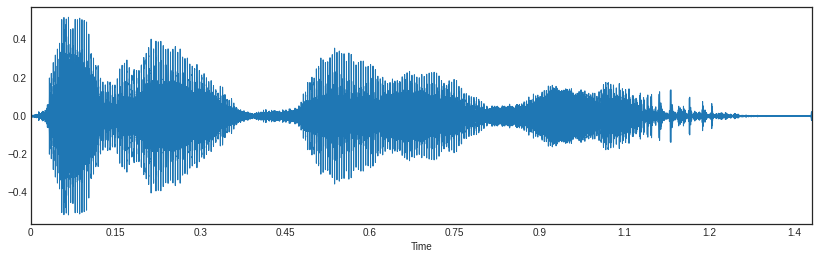

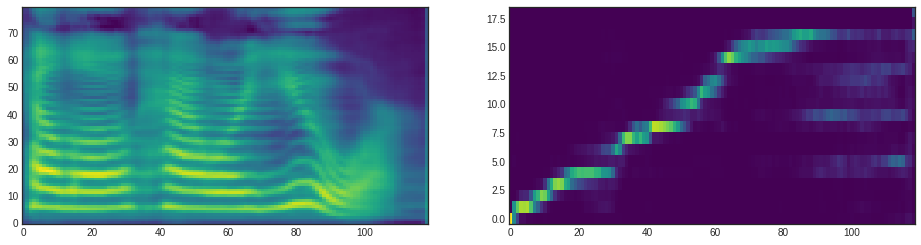

In [6]:
import librosa.display
from IPython.display import Audio

text = 'Hello, how are you?'
mel_output_postnet, alignment, audio_np, sampling_rate  = TTS(text)
#mel_output, mel_output_postnet, alignment, audio_np, sampling_rate = TTS(text)

fig = plt.figure(figsize=(14,4))
librosa.display.waveplot(audio_np, sr=sampling_rate)
plot_data((mel_output_postnet, alignment))
#plot_data((mel_output, mel_output_postnet, alignment))
Audio(audio_np, rate=sampling_rate)

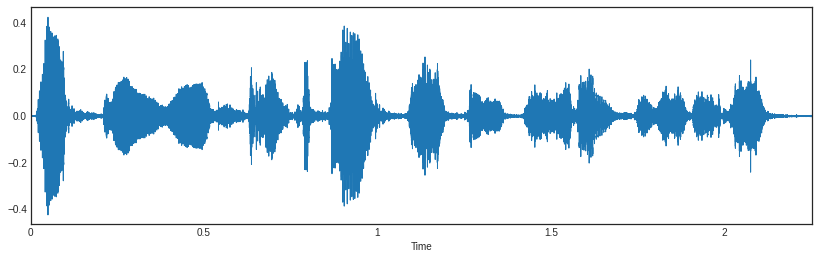

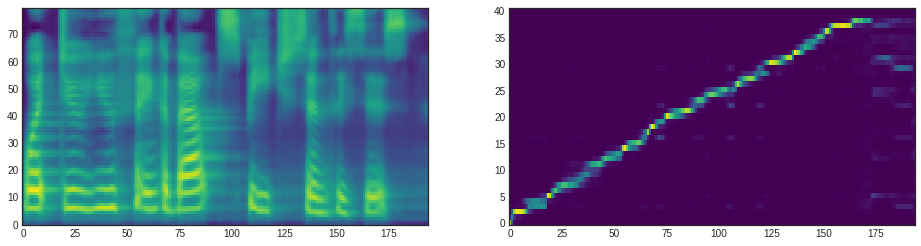

In [7]:
text = 'What do you think about speech synthesis?'
mel_output_postnet, alignment, audio_np, sampling_rate  = TTS(text)

fig = plt.figure(figsize=(14,4))
librosa.display.waveplot(audio_np, sr=sampling_rate)
plot_data((mel_output_postnet, alignment))
Audio(audio_np, rate=sampling_rate)

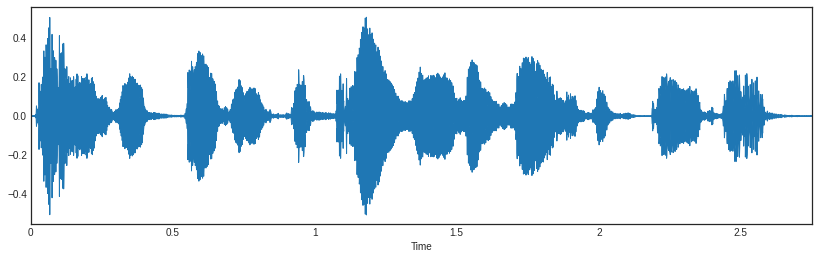

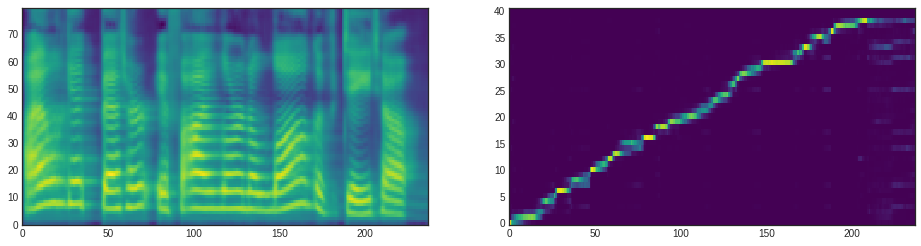

In [8]:
text = "I'll get better if I learn a log of data."
mel_output_postnet, alignment, audio_np, sampling_rate  = TTS(text)

fig = plt.figure(figsize=(14,4))
librosa.display.waveplot(audio_np, sr=sampling_rate)
plot_data((mel_output_postnet, alignment))
Audio(audio_np, rate=sampling_rate)